# Linear Models for Sequential Trajectory Prediction

This notebook demonstrates my first steps in exploring the trajectory prediction problem with neural networks. Here, I explore how to predict the position of a **free-falling** single ball on the next frame of the simulation using concatenated positions of the same ball in the previous three frames.

- Three frames are used to make assure that this prediction is possible analytically. Using numerical differentiation, velocity of the object can be approximated as difference of positions over the time interval, and acceleration - as difference in velocities over the time interval, there the interval equals to 1 simulation step. Thus, triplet of coordinates would be enough to predict the following coordinates analytically, and I expect simple linear models to be able to learn this prediction.

Using Phyre, I generated a dataset of a single ball in free-fall. Essentially, I am only focused on the time when ball is in the free-fall. However, I did not remove the part of the simulation when the ball collides with the floor to see how the simplest models will be able to deal with this situation, with a hope that it will inspire my next steps.

I used three different modification of simple linear models to make such predictions. I then mapped the predicted results into a plot to see the predictions for the entire scenario. It is important to not be confused by these plots - the models do not predict the entire trajectory, but rather only a single frame at a time.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import sys

if '..' not in sys.path:
    sys.path.append('..')
    
from data import OneBallFreeFallThreeFramesDataset

from models.LinearModelsForSequential1DFreeFall import SequentialDense1DFreeFallModel, SequentialLinearWithCtgVelocity1DFreeFallModel, SequentialKinem1DFreeFallModel

Let's start with importing the dataset.

In [2]:
train_data, test_data = OneBallFreeFallThreeFramesDataset.train_test_split('../data/raw/single-ball-free-fall', test_frac=0.3)

Test size:  1608
train_test_split response: test fraction rounded to 0.2999440402909905 (1608 simulations)


In this scenario, the length of each simulation is different. To avoid dimensional mismatch, we have to use the batch size of 1.

In [3]:
batch_size = 1

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Simple dense network with ReLU activations

The first model that I tried is a simple three-layer linear network is ReLU activations. The hidden layer only has two neurons that are supposed to symbolize velocity and acceleration. The schematic representation of this model is shown below.

<img src="../visuals/1D_sequential_free-fall_dense.png" width=800>

The reason why the ReLU activation is added to the output layer is in the form of data that we are dealing with - the simulator provides coordinates of the object relative to the size of the scene, so they are always bound between 0 and 1. The last ReLU activation assures that the network does not make negative predictions.

In [6]:
model1 = SequentialDense1DFreeFallModel()
print(model1)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)


# Training the model on 100 epochs
num_epochs = 100

# This array will store the loss values per epoch
loss_per_epoch = []

# This variable is needed to calculate the total epoch loss
epoch_loss = 0

# Training
epoch = 0
while epoch < num_epochs:
    for X, y in train_dataloader:
        # For each data instance we need to reset the optimizer gradients
        optimizer.zero_grad()
        
        pred = model1(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    if epoch_loss > 8:
        print(f'Unsuccessful start. Loss: {epoch_loss}')
        model1 = SequentialDense1DFreeFallModel()
        optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)
        epoch_loss = 0
        continue

    loss_per_epoch.append(epoch_loss)

    
    # Keeping training log
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    
    epoch_loss = 0
    epoch += 1

SequentialDense1DFreeFallModel(
  (hidden): Linear(in_features=3, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
)
Unsuccessful start. Loss: 226.33353577194794
Unsuccessful start. Loss: 226.33353577194794
Unsuccessful start. Loss: 8.851412906425102
Unsuccessful start. Loss: 226.33353577194794
Epoch 0 complete. Training loss: 7.976343155357483
Epoch 1 complete. Training loss: 2.440539316405747
Epoch 2 complete. Training loss: 2.1451550020296013
Epoch 3 complete. Training loss: 2.0597964385234775
Epoch 4 complete. Training loss: 1.9851578659329059
Epoch 5 complete. Training loss: 1.909558959689969
Epoch 6 complete. Training loss: 1.8348220051429216
Epoch 7 complete. Training loss: 1.7630931685353701
Epoch 8 complete. Training loss: 1.6953563608122006
Epoch 9 complete. Training loss: 1.6337832769499516
Epoch 10 complete. Training loss: 1.5792736474453162
Epoch 11 complete. Training loss: 1.5322215348337545
Epoch 12 complete. Training loss: 1.492165

The plot below show the training loss per epoch.

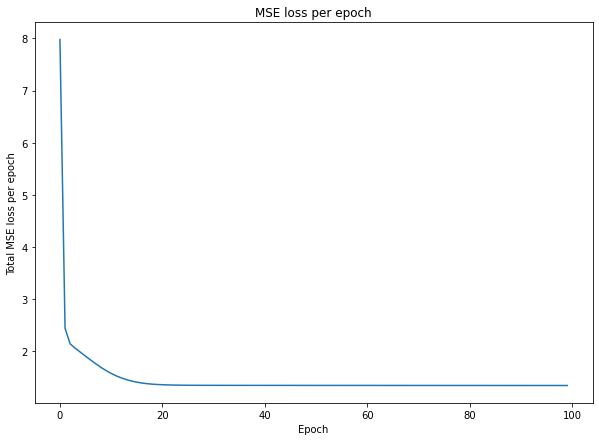

In [7]:
plt.figure(figsize=(10,7))
plt.plot(loss_per_epoch)
plt.title('MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Total MSE loss per epoch')
plt.show()

Finally, let's take a look at the first 10 predicted "trajectories" - predictions that correspond to a single scenario.

Test set RMSE loss: 0.018277347087860107


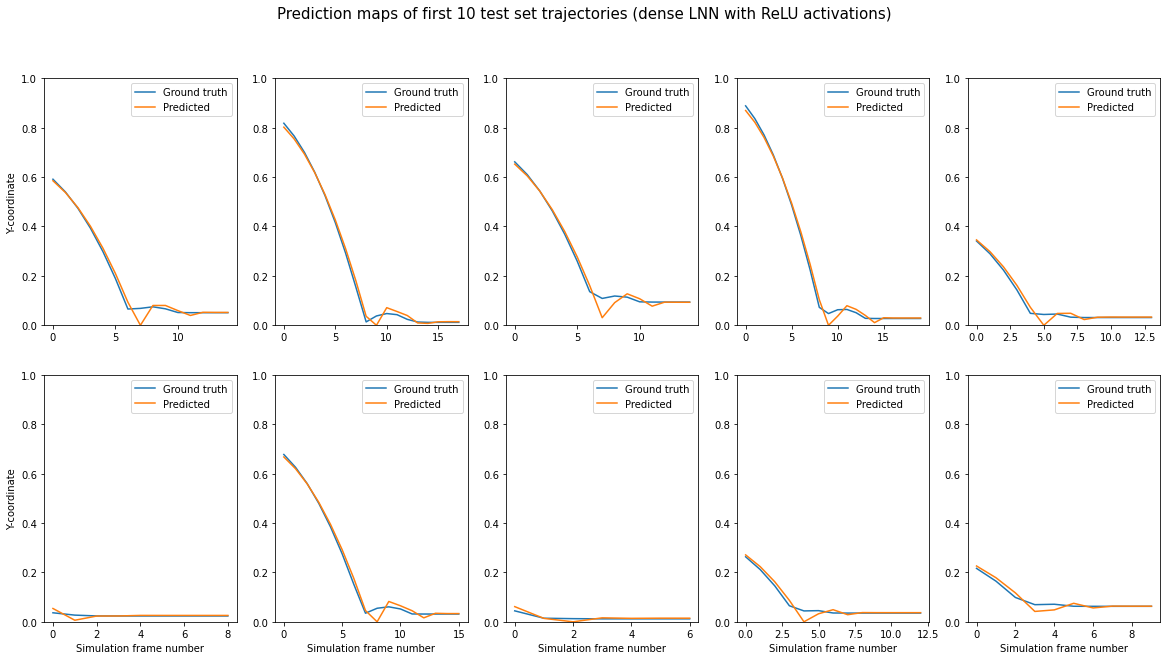

In [33]:
print(f'Test set RMSE loss: {(np.sum( [loss_fn(model1(X), y) for X, y in test_dataloader] ) / len(test_data)) ** 0.5}')

count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))

    for row_id in range(len(axs)):
        for col_id in range(len(axs[0])):
            axs[row_id, col_id].set_ylim(0, 1)


    fig.suptitle('Prediction maps of first 10 test set trajectories (dense LNN with ReLU activations)', fontsize=15)
    plt.setp(axs[-1, :], xlabel='Simulation frame number')
    plt.setp(axs[:, 0], ylabel='Y-coordinate')

    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model1(X)
        axs[int(count >= 5)][count % 5].plot(y.reshape(1,-1)[0], label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(pred.reshape(1,-1)[0], label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

# Linear network with ReLU and Cotan activations in the hidden layer

**TODO: Ask Watson about it and make a write up**

<img src="../visuals/1D_sequential_free-fall_dense_ctg.png" width=800>

In [11]:
model2 = SequentialLinearWithCtgVelocity1DFreeFallModel()
print(model2)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)


# Training the model on 100 epochs
num_epochs = 100

# This array will store the loss values per epoch
loss_per_epoch = []

# This variable is needed to calculate the total epoch loss
epoch_loss = 0

# Training
epoch = 0
while epoch < num_epochs:
    for X, y in train_dataloader:
        # For each data instance we need to reset the optimizer gradients
        optimizer.zero_grad()
        
        pred = model2(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    if epoch_loss > 8:
        print(f'Unsuccessful start. Loss: {epoch_loss}')
        model2 = SequentialDense1DFreeFallModel()
        optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)
        epoch_loss = 0
        continue
        
    loss_per_epoch.append(epoch_loss)
    
    # Keeping training log
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    
    epoch_loss = 0
    epoch += 1

SequentialLinearWithCtgVelocity1DFreeFallModel(
  (velocity): Linear(in_features=3, out_features=1, bias=True)
  (acceleration): Linear(in_features=3, out_features=1, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
)
Unsuccessful start. Loss: 12.22703597206782
Unsuccessful start. Loss: 226.33353577194794
Unsuccessful start. Loss: 226.33353577194794
Unsuccessful start. Loss: 226.33353577194794
Unsuccessful start. Loss: 226.33353577194794
Unsuccessful start. Loss: 226.33353577194794
Epoch 0 complete. Training loss: 5.43015846012014
Epoch 1 complete. Training loss: 1.8024519637637582
Epoch 2 complete. Training loss: 1.134237504455851
Epoch 3 complete. Training loss: 1.0551255220173772
Epoch 4 complete. Training loss: 1.0139692422549444
Epoch 5 complete. Training loss: 0.9851290017646832
Epoch 6 complete. Training loss: 0.9620747465039987
Epoch 7 complete. Training loss: 0.9408718782167167
Epoch 8 complete. Training loss: 0.9204592618373564
Epoch 9 complete. Trainin

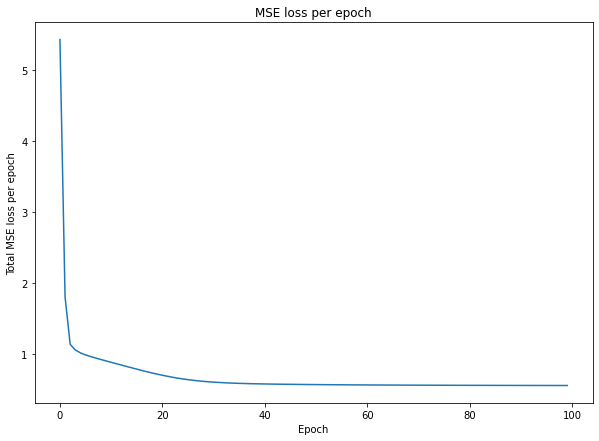

In [12]:
plt.figure(figsize=(10,7))
plt.plot(loss_per_epoch)
plt.title('MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Total MSE loss per epoch')
plt.show()

Test set loss: 0.011553567834198475


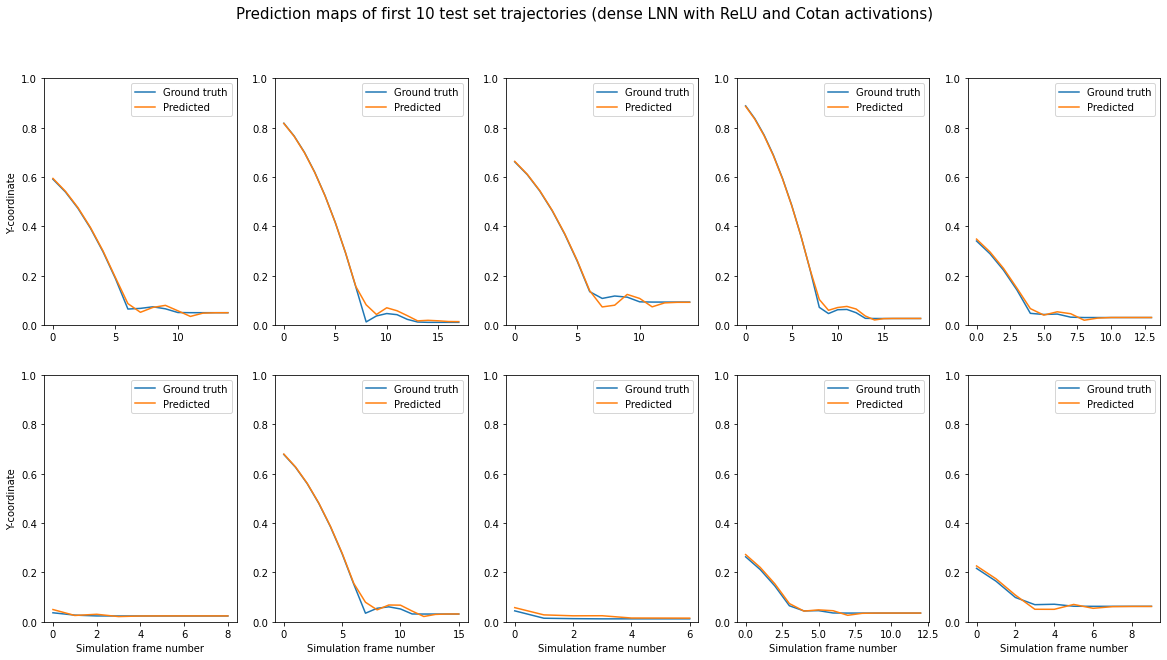

In [31]:
print(f'Test set loss: {(np.sum( [loss_fn(model2(X), y) for X, y in test_dataloader] ) / len(test_data)) ** 0.5}')

count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))

    for row_id in range(len(axs)):
        for col_id in range(len(axs[0])):
            axs[row_id, col_id].set_ylim(0, 1)
    
    fig.suptitle('Prediction maps of first 10 test set trajectories (dense LNN with ReLU and Cotan activations)', fontsize=15)   
    plt.setp(axs[-1, :], xlabel='Simulation frame number')
    plt.setp(axs[:, 0], ylabel='Y-coordinate')

    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model2(X)
        axs[int(count >= 5)][count % 5].plot(y.reshape(1,-1)[0], label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(pred.reshape(1,-1)[0], label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

# Linear network with direct connection of one of the inputs to the output

This network architecture is inspired by the kinematic formulas. According to them,

$$y = y_0 - v_0 t - \frac{gt^2}{2}$$

I thought that if my hidden neurons are meant to represent velocity and acceleration, then mocking this formula by adding a direct connection from one of the inputs to the output can lead to better results. The schematic representation of this network is given below.

<img src="../visuals/1D_sequential_free-fall_dense_direct_connection.png" width=800>

In [14]:
model3 = SequentialKinem1DFreeFallModel()
print(model3)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate)


# Training the model on 100 epochs
num_epochs = 100

# This array will store the loss values per epoch
loss_per_epoch = []

# This variable is needed to calculate the total epoch loss
epoch_loss = 0

# Training
epoch = 0
while epoch < num_epochs:
    for X, y in train_dataloader:
        # For each data instance we need to reset the optimizer gradients
        optimizer.zero_grad()
        
        pred = model3(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    if epoch_loss > 8:
        print(f'Unsuccessful start. Loss: {epoch_loss}')
        model3 = SequentialDense1DFreeFallModel()
        optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate)
        epoch_loss = 0
        continue    
    
    loss_per_epoch.append(epoch_loss)
    
    # Keeping training log
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    
    epoch_loss = 0
    epoch += 1

SequentialKinem1DFreeFallModel(
  (hidden): Linear(in_features=3, out_features=2, bias=True)
  (output): Linear(in_features=3, out_features=1, bias=True)
)
Epoch 0 complete. Training loss: 4.725568990821557
Epoch 1 complete. Training loss: 2.6888973006644505
Epoch 2 complete. Training loss: 1.8588518005799468
Epoch 3 complete. Training loss: 1.6548178719932505
Epoch 4 complete. Training loss: 1.6056185941960548
Epoch 5 complete. Training loss: 1.5782027574971025
Epoch 6 complete. Training loss: 1.5543246548623206
Epoch 7 complete. Training loss: 1.5312389135021216
Epoch 8 complete. Training loss: 1.509172584804059
Epoch 9 complete. Training loss: 1.488487088435122
Epoch 10 complete. Training loss: 1.4690612501366735
Epoch 11 complete. Training loss: 1.4508645373907305
Epoch 12 complete. Training loss: 1.4342639050851345
Epoch 13 complete. Training loss: 1.4190978312909106
Epoch 14 complete. Training loss: 1.4056223693713896
Epoch 15 complete. Training loss: 1.3937488217879732
Epoch 16 

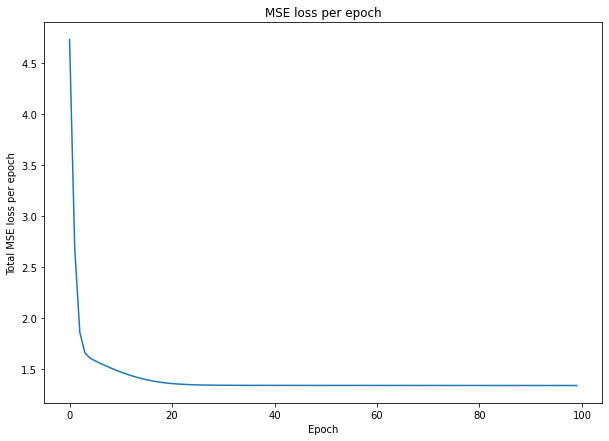

In [15]:
plt.figure(figsize=(10,7))
plt.plot(loss_per_epoch)
plt.title('MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Total MSE loss per epoch')
plt.show()

Test set loss: 0.0181919876486063


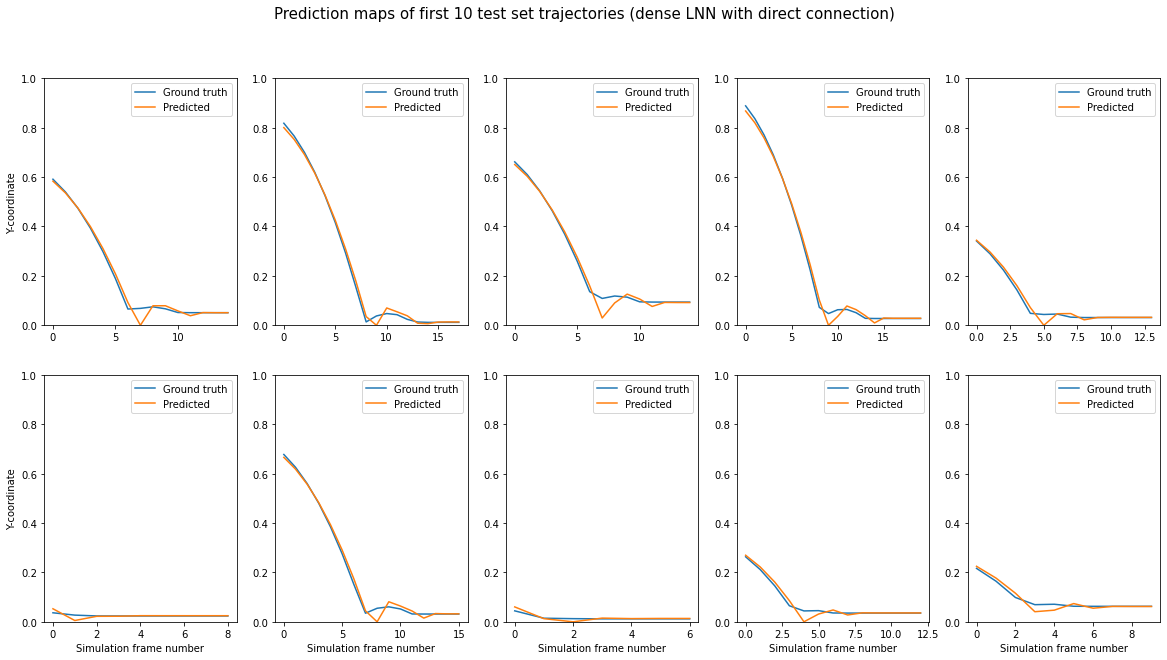

In [34]:
print(f'Test set loss: {(np.sum( [loss_fn(model3(X), y) for X, y in test_dataloader] ) / len(test_data)) ** 0.5}')

count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))

    for row_id in range(len(axs)):
        for col_id in range(len(axs[0])):
            axs[row_id, col_id].set_ylim(0, 1)

    fig.suptitle('Prediction maps of first 10 test set trajectories (dense LNN with direct connection)', fontsize=15)
    plt.setp(axs[-1, :], xlabel='Simulation frame number')
    plt.setp(axs[:, 0], ylabel='Y-coordinate')

    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model3(X)
        axs[int(count >= 5)][count % 5].plot(y.reshape(1,-1)[0], label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(pred.reshape(1,-1)[0], label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

Text(0, 0.5, 'Y-coordinate')

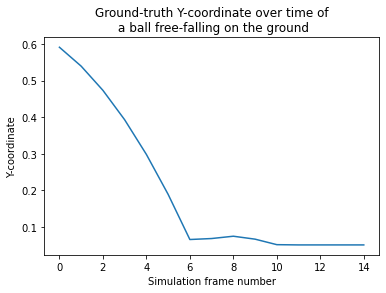

In [27]:
_, yd = test_data[0]

plt.plot(yd)
plt.title('Ground-truth Y-coordinate over time of\n a ball free-falling on the ground')
plt.xlabel('Simulation frame number')
plt.ylabel('Y-coordinate')

## Conclusion

**TODO: write it up**